# Artificial Intelligence II (Deep Learning for Natural Language Processing)
# Homework 1

Name: Maria Miliou \
ID: 1115201300101 

In [30]:
# Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, recall_score,precision_score,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline

## Loading and Exploring Dataset

In [31]:
# Data file located at git
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
train_df = pd.read_csv("/content/drive/MyDrive/imdb-reviews.csv", sep='\t')

test_df = pd.DataFrame() # You can delete ths line if test_set is provided as below or just modify as suggested

# HERE ADD TEST DATAFRAME EXAMPLE
#test_df = pd.read_csv("/content/drive/MyDrive/your_part.csv", sep='\t')

print(train_df.describe())
train_df.head()

             rating
count  45008.000000
mean       5.481914
std        3.494293
min        1.000000
25%        2.000000
50%        7.000000
75%        9.000000
max       10.000000


,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


In [33]:
# Find sentiment

train_df['sentiment'] = train_df['rating'].apply(lambda x:0 if x<=4.0 else 1)
if not(test_df.empty):
  test_df['sentiment'] = train_df['rating'].apply(lambda x:0 if x<=4.0 else 1)

train_df.head()


,url,rating,review,sentiment
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...,1


##Data Pre-processing

In [34]:
# Clean data from urls, emails and punctation
# Train
train_df['review'] = train_df['review'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
train_df['review'] = train_df['review'].replace(r'\S*@\S*\s?', '', regex=True)
train_df['review'] = train_df['review'].replace(r'[^\w\s]', '', regex=True)

# Test
if not(test_df.empty) :
  test_df['review'] = test_df['review'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
  test_df['review'] = test_df['review'].replace(r'\S*@\S*\s?', '', regex=True)
  train_df['review'] = train_df['review'].replace(r'[^\w\s]', '', regex=True)



In [35]:
# Split data to validation and train sets if no test set provided

if not(test_df.empty):
  X_train = train_df['review']
  X_val = test_df['review']
  y_train = np.array(train_df['sentiment'])
  y_val = np.array(test_df['sentiment'])
else:
  X_train, X_val, y_train, y_val = train_test_split(train_df['review'], train_df['sentiment'], test_size=0.2)


## Classification

In [36]:
# Define stop words
def stopwrds():
  mywords=frozenset(['not', 'no', 'didnt','cannot', 'couldnt', 'never'])
  stopw = ENGLISH_STOP_WORDS.union(['br'])
  stopw = stopw.difference(mywords)
  return list(stopw)


F1 score:  0.8772389689820882
precision score:  0.8762819114117391
recall score:  0.8781981193964574


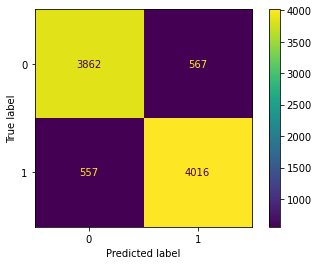

In [37]:
# Vectorize and learn
tfidf = TfidfVectorizer(stop_words = stopwrds(), lowercase=True, max_features=2000)
clf = LogisticRegression(solver = 'saga', penalty = 'l2', max_iter =1000)
model=Pipeline([('vect',tfidf), ('classifier',clf)])
model.fit(X_train, y_train)

# Cross_validation check
#res=cross_val_score(model, X_train, y_train, cv=5, scoring ="f1")
#print("Average cross validation results: ", np.mean(res))

# Predict
y_pred = model.predict(X_val)

# Calculate metrics
print("F1 score: ", f1_score(y_val, y_pred))
print("precision score: ", precision_score(y_val, y_pred))
print("recall score: ", recall_score(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred), display_labels=clf.classes_)
disp.plot()
plt.show()



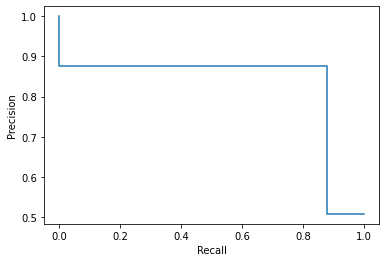

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_val, y_pred, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

## Evaluating the model/predictions

### Evaluate model by train size

In [39]:
list_f1_train = []
list_f1 = []
list_samples = []
list_rmse_train = []
list_rmse = []
list_recall_train = []
list_recall = []
list_pr_train = []
list_pr = []
for times in range(10):
  X, X_unused, y, y_unused = train_test_split(X_train, y_train, test_size = 1 - (times*0.1 + 0.001))

  # Classification
  tfidf = TfidfVectorizer(stop_words=stopwrds(),lowercase=True, max_features=2000)
  clf = LogisticRegression(solver = 'saga', penalty = 'l2', max_iter =1000)
  model=Pipeline([('vect',tfidf), ('classifier',clf)])
  model.fit(X, y)

  # Train set predictions
  y_pred_train = model.predict(X)

  # Test/Validation set predictions
  y_pred = model.predict(X_val)

  # Find scores
  # Train
  f1_train = f1_score(y, y_pred_train)
  print("Train f1 score: ", f1_train)

  rmse_train = mean_squared_error(y, y_pred_train, squared = False) #squared = False--->returns rmse

  pr_train = precision_score(y, y_pred_train)

  recall_train = recall_score(y, y_pred_train)

  # Test
  f1 = f1_score(y_val, y_pred)
  print("Test f1 score: ", f1)
  rmse = mean_squared_error(y_val, y_pred, squared = False)  #squared = False--->returns rmse

  pr = precision_score(y_val, y_pred)

  recall = recall_score(y_val, y_pred)

  # Keep reults for plot
  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_samples.append(times*0.1 + 0.001)
  list_rmse_train.append(rmse_train)
  list_rmse.append(rmse)
  list_recall_train.append(recall_train)
  list_recall.append(recall)
  list_pr_train.append(pr_train)
  list_pr.append(pr)


Train f1 score:  1.0
Test f1 score:  0.008273459612453734
Train f1 score:  0.9161793372319688
Test f1 score:  0.8552488589437078
Train f1 score:  0.9094695917800611
Test f1 score:  0.8618700337433329
Train f1 score:  0.9044809146229026
Test f1 score:  0.867883528900478
Train f1 score:  0.9008102822017323
Test f1 score:  0.8744551002615518
Train f1 score:  0.9024753294007387
Test f1 score:  0.871900826446281
Train f1 score:  0.8980607121470358
Test f1 score:  0.8712352684417285
Train f1 score:  0.8960956175298805
Test f1 score:  0.8765836609873306
Train f1 score:  0.896682791983414
Test f1 score:  0.8782400348507952
Train f1 score:  0.8956086168218554
Test f1 score:  0.8780806979280262


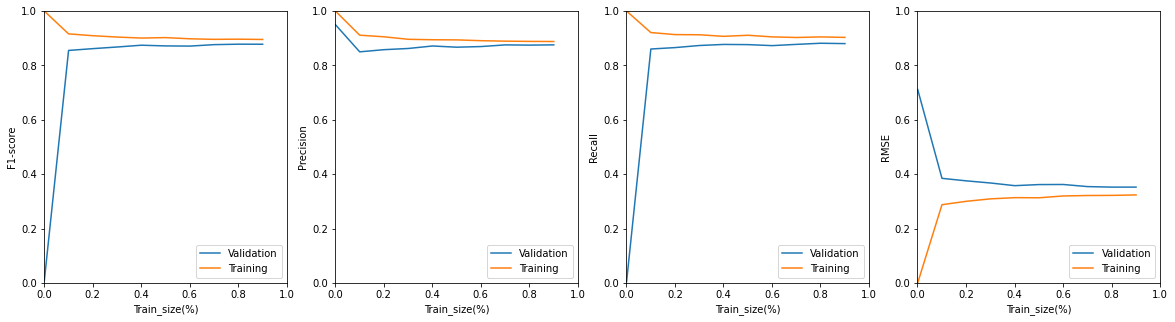

In [40]:
# Ploting results

def plot_curve(metric, figure, list_x, list_x_train):
  plt.subplot(1, 4, figure)
  plt.plot(list_samples, list_x, label = "Validation")
  plt.plot(list_samples, list_x_train, label = "Training")
  plt.ylim(ymin=0, ymax=1.0)
  plt.xlim(xmin=0, xmax=1.0)
  plt.legend(loc=4)
  plt.ylabel(metric)
  plt.xlabel("Train_size(%)")

plt.figure(figsize=(20, 5))

plot_curve("F1-score", 1, list_f1, list_f1_train)
plot_curve("Precision", 2, list_pr, list_pr_train)
plot_curve("Recall", 3, list_recall, list_recall_train)
plot_curve("RMSE", 4, list_rmse, list_rmse_train)


### Evaluate by trying different solvers and penalties to LogisticRegression

In [41]:
def evaluate(penalty, solver,C, max_iter):
  tfidf_eval = TfidfVectorizer(stop_words=stopwrds(),lowercase=True, max_features=2000)
  clf_eval = LogisticRegression(penalty=penalty, solver=solver, max_iter=max_iter, C=C)
  model_eval=Pipeline([('vect',tfidf_eval),('classifier',clf_eval)])
  model_eval.fit(X_train, y_train)

  y_pred = model_eval.predict(X_val)
  f1.append(f1_score(y_val, y_pred))
  print(f1_score(y_val, y_pred))
  precision.append(precision_score(y_val, y_pred))
  recall.append(recall_score(y_val, y_pred))
  accuracy.append(accuracy_score(y_val, y_pred))


In [42]:
solvers=['liblinear', 'liblinear', 'saga', 'saga', 'saga', 'lbfgs', 'lbfgs']
penalties=['l2', 'l1', 'l2', 'l1', 'none', 'l2', 'none']

accuracy=[]
precision=[]
recall=[]
f1=[]

for i in range(len(solvers)):
  
  print("Solver: ", solvers[i])
  print("Penalty: ", penalties[i])
  evaluate(penalties[i] , solvers[i], 1.0, 1000)

Solver:  liblinear
Penalty:  l2
0.8772389689820882
Solver:  liblinear
Penalty:  l1
0.8765418622421133
Solver:  saga
Penalty:  l2
0.8772389689820882
Solver:  saga
Penalty:  l1
0.8765418622421133
Solver:  saga
Penalty:  none
0.8703176341730557
Solver:  lbfgs
Penalty:  l2
0.8772389689820882
Solver:  lbfgs
Penalty:  none
0.8703176341730557


0.8767144644554583
0.8759978849526525
0.8767144644554583
0.8759978849526525
0.8698579801931445
0.8767144644554583
0.8698579801931445


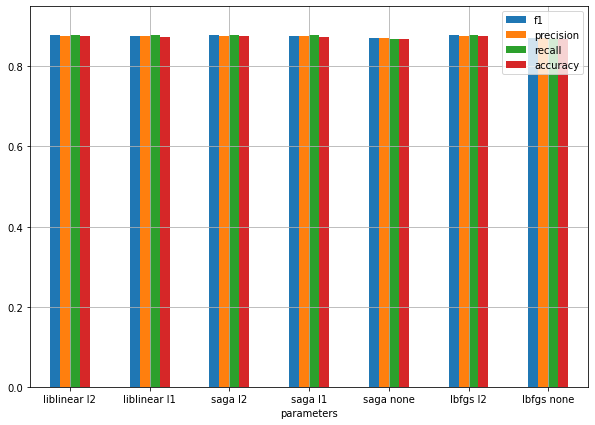

In [43]:
# Plot
names = ['liblinear l2', 'liblinear l1', 'saga l2', 'saga l1', 'saga none', 'lbfgs l2', 'lbfgs none']
results = np.random.rand(7,4)
results[:, 0] = f1
results[:, 1] = precision
results[:, 2] = recall
results[:, 3] = accuracy

df = pd.DataFrame(results, columns=["f1", "precision", "recall", "accuracy"])
df['parameters'] = names
ax = df.plot(x="parameters", y=["f1", "precision", "recall", "accuracy"], kind="bar", rot=0, figsize=(10, 7), ylim=(0, 0.95), grid=True)

for i in range(7):
  print(np.sum(results[i, :], axis=0 )/4)

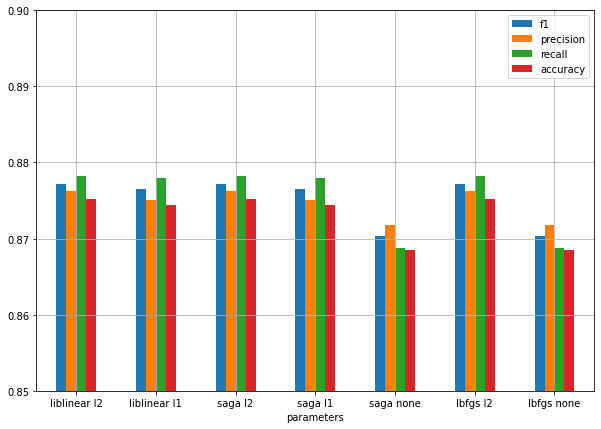

In [44]:
# Closer view
ax = df.plot(x="parameters", y=["f1", "precision", "recall", "accuracy"], kind="bar", rot=0, figsize=(10, 7), ylim=(0.85, 0.9), grid=True)

### Evaluate by inverse of regularization strength (C)
Smaller values specify stronger regularization

In [45]:
accuracy=[]
precision=[]
recall=[]
f1=[]

frange = [.1*x for x in range(5, 50, 5)]
print(frange)
for c in frange:
  print("C=", c)
  evaluate('l2' , 'saga', c, 1000)

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
C= 0.5
0.8772197407124961
C= 1.0
0.8772389689820882
C= 1.5
0.8763652249890782
C= 2.0
0.8760926573426573
C= 2.5
0.8752050749207043
C= 3.0
0.8744806472774985
C= 3.5
0.8742488801485853
C= 4.0
0.8737842858703967
C= 4.5
0.8734426229508196
